# AssurPrime : Saurez-vous prédire la prime d'assurance ?

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/auduvignac/challengedata_ens_AssurPrime/blob/main/notebooks/exploration/assurprim_modeling_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# Contexte

Crédit Agricole Assurances est une filiale du Groupe Crédit Agricole dédiée à l’assurance, faisant de celui-ci un acteur multi-expert de la bancassurance et le 1er bancassureur en Europe.
Crédit Agricole Assurances regroupe plusieurs entités, dont Predica et Pacifica, qui proposent une large gamme d’assurances aux particuliers, aux exploitants agricoles, aux professionnels et aux entreprises. Crédit Agricole Assurances s’engage à offrir des solutions innovantes et adaptées aux besoins des clients, tout en favorisant le développement durable et la responsabilité sociale.
Au sein de l’Académie Data Science du groupe, l’objectif est de participer activement à la montée en compétences des collaborateurs, de partager des connaissances et d’identifier de nouveaux usages.

# Objectif

Le contrat Multirisque Agricole, géré par Pacifica, est souscrit par les agriculteurs pour sécuriser leur exploitation. Il couvre l’activité professionnelle, les dommages aux bâtiments d’exploitation, le matériel stocké, ainsi que la protection financière et juridique. Ce contrat garantit à l’assuré une couverture efficace et durable, assurant ainsi la continuité de son activité en cas de sinistre, tant sur le plan matériel que financier.

Actuellement, le risque d’incendie constitue une part majeure de la charge sinistre du contrat Multirisque Agricole, ce qui en fait un enjeu clé à modéliser avec précision.

L’objectif est d’identifier le meilleur modèle pour prédire la prime pure incendie, en utilisant :
- Un modèle pour la Fréquence,
- Un modèle pour le Coût moyen.

La variable cible finale, la charge, est obtenue en multipliant la fréquence, le coût moyen, et le nombre d’années depuis la souscription du contrat (la variable `ANNEE_ASSURANCE`).

# Description des données

Un fichier supplémentaire est mis à disposition regroupant toutes les variables disponibles, accompagnées de leur description. Ce fichier inclut :

- **Les variables cibles** : `FREQ`, `CM`, et `CHARGE`
- **Données géographiques** : département, données météorologiques, etc.
- **Données spécifiques au contrat**, notamment :
    - L’activité de l’assuré (cultivateur, polyculteur, etc.)
    - Les indicateurs de souscription des garanties
    - Le nombre de bâtiments, de salariés, et de sinistres déclarés lors de la souscription
    - **Données de surface** : surfaces des bâtiments (élevage, exploitation, etc.), anonymisées en `surface1`, `surface2`, etc., pour garantir la confidentialité
    - **Données de capitaux** : capitaux assurés pour différentes options (vol, serres, etc.), anonymisés en `capital1`, `capital2`, etc.
    - **Données liées à la prévention** : présence d’équipements (extincteurs, structure en bois, etc.), anonymisées en `prev1`, `prev2`, etc.


# Description du *benchmark*

## Objectif du challenge

L’objectif de ce challenge est de comparer les performances des modèles développés dans le cadre de cette compétition avec celles d’un modèle de référence basé sur des **GLM (Generalized Linear Models)** classiques.

## Structure du benchmark

Le benchmark repose sur deux modèles **GLM** distincts :

- Fréquence des sinistres :
    - Distribution : *Loi de Poisson* ;
    - Fonction de lien : *Log*.

- Coût moyen d’un sinistre :
    - Distribution : *Tweedie* ;
    - Fonction de lien : *Log*.

## Évaluation

L’évaluation des modèles repose sur une métrique unique : **RMSE (Root Mean Square Error)**, définie par la formule suivante :

$$\text{RMSE} = \sqrt{\frac{1}{n} \sum\limits_{i=1}^{n} (y_i - \hat{y}_i)^2}$$

où :
- $y_i$ représente la valeur réelle ;
- $\hat{y}_i$ représente la valeur prédite ;
- $n$ est le nombre d’observations.

L’idée reste d’évaluer dans quelle mesure les approches proposées permettent de dépasser les performances des modèles standards tout en prenant en compte :

- La précision des prédictions ;
- Les aspects d’interprétabilité et d’efficacité ;
- Les contraintes métier associées.

## Installation & Imports

In [2]:
!pip install -q category-encoders \
                matplotlib \
                numpy \
                pandas \
                scikit-learn \
                seaborn \
                xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.8 MB/s eta 0:00:00


In [ ]:
from category_encoders import CountEncoder
from IPython.display import display
from scipy.stats import chi2_contingency
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import classification_report, fbeta_score, mean_squared_error, make_scorer, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, XGBRegressor

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Chargement et aperçu des données

In [22]:
# Chargement et aperçu des données
try:
    print("Chargement des données...")

    X_train_url = "https://media.githubusercontent.com/media/auduvignac/challengedata_ens_AssurPrime/refs/heads/main/data/raw/x_train.csv"
    X_train = pd.read_csv(X_train_url)

    y_train_url = "https://media.githubusercontent.com/media/auduvignac/challengedata_ens_AssurPrime/refs/heads/main/data/raw/y_train.csv"
    y_train = pd.read_csv(y_train_url)

    # X_test_url = "https://media.githubusercontent.com/media/auduvignac/challengedata_ens_AssurPrime/refs/heads/main/data/raw/x_test.csv"
    # X_test = pd.read_csv(X_test_url)

    print("Données chargées avec succès.\n")

    print("Aperçu de X_train :")
    display(X_train.head())

    print("\nAperçu de y_train :")
    display(y_train.head())

except Exception as e:
    print("Erreur lors du chargement des données. Vérifiez que les URLs sont correctes.")
    print(e)


Chargement des données...


<ipython-input-22-84e3d83bcfe5>:6: DtypeWarning: Columns (16,17,29,30,31,126,128,129,132,133,135,138,371) have mixed types. Specify dtype option on import or set low_memory=False.
  X_train = pd.read_csv(X_train_url)


Données chargées avec succès.

Aperçu de X_train :


,ID,ACTIVIT2,VOCATION,TYPERS,ANCIENNETE,ADOSS,CARACT1,CARACT2,CARACT3,INDEM1,...,NBJRR100_MMAX_A,NBJRR100_MSOM_A,RR_VOR_MM_A,RR_VOR_MMAX_A,RRAB_VOR_MM_A,RRAB_VOR_MMAX_A,ANNEE_ASSURANCE,ESPINSEE,AN_EXERC,ZONE
0,1,ACT1,VOC6,1,0,N,N,NaN,NaN,N,...,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,ANNEE5,3
1,2,ACT1,VOC6,1,0,N,N,NaN,NaN,N,...,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,ANNEE5,3
2,3,ACT1,VOC6,1,2,N,R,NaN,NaN,N,...,NaN,NaN,NaN,NaN,NaN,NaN,0.402740,NaN,ANNEE5,3
3,4,ACT1,VOC6,2,0,N,N,NaN,NaN,N,...,NaN,NaN,NaN,NaN,NaN,NaN,0.246575,NaN,ANNEE5,3
4,5,ACT1,VOC6,2,1,N,N,NaN,NaN,N,...,01. <= 0,01. <= 0,03. <= 102,03. <= 232,04. >= 25,02. <= 57,0.838356,NaN,ANNEE5,3



Aperçu de y_train :


,ID,FREQ,CM,ANNEE_ASSURANCE,CHARGE
0,1,0.0,0.0,1.000000,0.0
1,2,0.0,0.0,1.000000,0.0
2,3,0.0,0.0,0.402740,0.0
3,4,0.0,0.0,0.246575,0.0
4,5,0.0,0.0,0.838356,0.0


## Inspection des données

### Types de colonnes

In [23]:
# Affichage du type des données de X_train
pd.set_option('display.max_rows', None)

print("Types des données de X_train :")
print(X_train.dtypes)

Types des données de X_train :
ID                              int64
ACTIVIT2                       object
VOCATION                       object
TYPERS                          int64
ANCIENNETE                      int64
ADOSS                          object
CARACT1                        object
CARACT2                       float64
CARACT3                        object
INDEM1                         object
DUREE_REQANEUF                float64
CARACT4                        object
CARACT5                         int64
TYPBAT1                        object
INDEM2                         object
TYPBAT2                         int64
FRCH1                          object
FRCH2                          object
DEROG1                         object
DEROG2                         object
DEROG3                         object
DEROG4                         object
DEROG5                         object
DEROG6                         object
DEROG7                         object
DEROG8             

Le nombre de variables étant conséquent, affichons-en un résumé pour mieux appréhender leur nature.

In [6]:
# Affichage synthétique des types de données
print("Résumé des types de données dans X_train :")
print(X_train.dtypes.value_counts())

Résumé des types de données dans X_train :
object     280
int64       58
float64     36
Name: count, dtype: int64


### Analyse des valeurs manquantes

Afin d'évaluer la qualité des données, analysons la quantité de valeurs manquantes dans chaque variable, afin d'identifier les colonnes problématiques et de réfléchir aux stratégies de traitement : suppression, imputation, ou autres méthodes adaptées.

Nous allons afficher :
- Le nombre de valeurs manquantes par colonne
- Leur proportion en pourcentage
- Un tri décroissant pour mieux visualiser les plus impactées


In [25]:
# Nombre et taux (%) de valeurs manquantes
nb_missing = X_train.isnull().sum()
taux_missing = X_train.isnull().mean() * 100

# DataFrame résumé
missing_info = pd.DataFrame({
    'Valeurs manquantes': nb_missing,
    'Taux (%)': taux_missing.round(2)
})

# Filtrage des colonnes avec au moins une valeur manquante
missing_info = missing_info[missing_info['Valeurs manquantes'] > 0]

# Tri décroissant par taux
missing_info = missing_info.sort_values(by='Taux (%)', ascending=True)

# Affichage
print("Résumé des valeurs manquantes :")
display(missing_info)

Résumé des valeurs manquantes :


,Valeurs manquantes,Taux (%)
KAPITAL33,3,0.00
KAPITAL31,3,0.00
KAPITAL18,48,0.01
KAPITAL20,268,0.07
KAPITAL15,624,0.16
KAPITAL24,834,0.22
KAPITAL17,889,0.23
KAPITAL19,1105,0.29
KAPITAL23,1161,0.30
KAPITAL16,1582,0.41


L'analyse révèle une proportion importante de variables avec des taux de valeurs manquantes élevés :

- **Totalement ou quasi totalement manquantes** : `DEROG14` (100%), `DEROG13` (99.66%), `DEROG16` (99.15%)
- **Taux très élevés (> 90%)** : `CARACT2`, `CARACT3`, `TYPBAT1`, `DEROG12`
- **Taux intermédiaires (56-62%)** : variables météo et distances (`RRAB_VOR_MM_A`, `DISTANCE_311`, etc.)
- **Taux modérés (20-40%)** : `RISK13`, `KAPITAL11`, `SURFACE8`, etc.
- **Taux faibles (< 10%)** : `MEN_MAIS`, `RISK1`, `FRCH2`, etc.

> **Remarques** :
- Les variables avec plus de 90% de valeurs manquantes seront possiblement exclues ;
- Certaines familles de variables (distances, météo) présentent une structure commune, ce qui permet d'envisager :
  - une **imputation croisée** entre variables similaires,
  - une **imputation par moyenne conditionnelle** selon des regroupements géographiques ou sociaux,
  - ou une **réduction préalable** (moyenne, ACP) pour simplifier l'information.

---

Un grand nombre de caractéristiques présentant un volume important de valeurs manquantes, l'enjeu est d'identifier celles qui n'apporteront rien au modèle, afin de **réduire la dimensionnalité**.

**Exemple** : les variables `DEROGnn`, avec plus de 99% de valeurs manquantes, seront probablement **inutiles pour prédire la fréquence du risque incendie**.

Il conviendra d'**arbitrer variable par variable**, en fonction de la cible (`FREQ` ou `CN`).  
Nous commencerons donc par **quantifier le taux de valeurs manquantes**.

In [9]:
# Analyse des valeurs uniques
unique_values = X_train.nunique().sort_values(ascending=False)
print("\nNombre de valeurs uniques par colonne :")
print(unique_values)


Nombre de valeurs uniques par colonne :
ID                            383610
ANNEE_ASSURANCE                 1113
NBSINSTRT                         94
ZONE                              93
SURFACE3                          65
SURFACE5                          65
SURFACE1                          65
SURFACE8                          65
SURFACE11                         65
SURFACE2                          65
SURFACE18                         61
NBSINCONJ                         53
RISK2                             49
NBBAT13                           31
NBBAT4                            31
NBBAT1                            30
RISK3                             27
EQUIPEMENT7                       22
EQUIPEMENT6                       22
NBBAT10                           21
KAPITAL25                         21
SURFACE7                          19
SURFACE10                         19
TAILLE3                           17
SURFACE6                          16
CARACT5                           

### Analyse du nombre de modalités uniques par variable

L'analyse du nombre de modalités uniques dans chaque variable permet d'anticiper leur traitement en modélisation (encodage, réduction, exclusion, etc.). Voici les principaux constats :

- **Variables à forte cardinalité** :
  - Certaines variables comme `ID` (383 610 valeurs uniques) ou `ANNEE_ASSURANCE` (>1000 modalités) présentent une **cardinalité extrêmement élevée**.
  - Ces variables sont soit des identifiants à exclure (`ID`), soit potentiellement bruitées si elles ne peuvent être regroupées.

- **Variables à cardinalité moyenne** :
  - On trouve plusieurs variables avec **entre 10 et 100 modalités**, typiquement des scores (`KAPITAL*`, `SURFACE*`, `RISK*`, etc.), qui nécessiteront un **encodage adapté** (ordinal, binning, ou encodage fréquentiel).

- **Variables à faible cardinalité ( ≤ 5 modalités)** :
  - Très nombreuses, notamment dans les familles `DEROG`, `EQUIPEMENT`, `RISK`, `CARACT`, etc.
  - Ces variables sont candidates à un **encodage one-hot**, ou pourront être exclues si elles sont redondantes ou peu informatives.

- **Cas particuliers** :
  - Des variables comme `DISTANCE_244` ou `IND_Y1_Y2` n'ont **qu'une seule modalité**, ce qui les rend inutiles pour l'apprentissage automatique (absence de variance).
  - Les variables avec très peu de modalités et beaucoup de valeurs manquantes devront être analysées conjointement pour juger de leur utilité.

> Cette vue apporte une première base pour :
> - identifier les variables à exclure (trop ou pas assez variées),
> - anticiper les stratégies d'encodage,
> - planifier des regroupements ou des transformations.

Il est important de noter que beaucoup de caractéristiques ont un nombre de valeurs uniques limité (par exemple 4) et sont de type `object`.

Générons des tables de contingence afin d'évaluer la distribution des variables qualitatives.

Ces tableaux permettront de :

- Visualiser la **fréquence de chaque modalité** des variables catégorielles ;
- Détecter les **modalités rares** ou déséquilibrées ;
- Identifier des variables potentiellement peu informatives (modalité unique, déséquilibre extrême)
- Préparer les décisions d'**encodage**, de **regroupement** ou d'**exclusion**

Cette étape est nécessaire pour anticiper le comportement des variables catégorielles dans les modèles, notamment ceux sensibles aux déséquilibres ou à la cardinalité élevée.

Pour les calculs des modèles, il nous faut convertir ces objets en catégories numériques.


In [26]:
# Table de contingence pour les variables catégorielles
# Sélection des colonnes catégorielles et tri alphabétique
categorical_cols = sorted(X_train.select_dtypes(include=['object', 'category']).columns)

# Affichage des tables de contingence
for col in categorical_cols:
    print(f"\nTable de contingence pour '{col}' :")
    print(X_train[col].value_counts())



Table de contingence pour 'ACTIVIT2' :
ACTIVIT2
ACT1    296563
ACT5     53709
ACT2     14359
ACT8      5650
ACT3      5335
ACT9      4459
ACT7      2201
ACT6      1007
ACT4       327
Name: count, dtype: int64

Table de contingence pour 'ADOSS' :
ADOSS
N    375557
O      8053
Name: count, dtype: int64

Table de contingence pour 'ALTITUDE_1' :
ALTITUDE_1
01. <= 190    94708
02. <= 438    45650
03. <= 794    17369
04. >= 794     8171
Name: count, dtype: int64

Table de contingence pour 'ALTITUDE_2' :
ALTITUDE_2
01. <= 239     235954
02. <= 588      90698
03. <= 1186     33470
04. >= 1186      4906
Name: count, dtype: int64

Table de contingence pour 'ALTITUDE_3' :
ALTITUDE_3
01. <= 236     236124
02. <= 579      90415
03. <= 1178     33554
04. >= 1178      4935
Name: count, dtype: int64

Table de contingence pour 'ALTITUDE_4' :
ALTITUDE_4
01. <= 143    206206
02. <= 333    105864
03. <= 645     38514
04. >= 645     14444
Name: count, dtype: int64

Table de contingence pour 'ALTITUDE_5' :

### Analyse quantitative des variables catégorielles

#### 1. Nombre de modalités
- Il apparaît une **grande hétérogénéité** dans le nombre de modalités :
  - Certaines variables ont **plus de 100 modalités** (ex : `ANNEE_ASSURANCE` avec 1113 valeurs uniques).
  - À l'inverse, un grand nombre de variables n'ont que **2 à 4 modalités**, comme `ADOSS`, `TYPERS`, `DEROG1`, etc.
- Plus de **150 variables** possèdent **moins de 5 modalités**, ce qui les rend **faciles à encoder** (binaire, label encoding...).
- Une large famille de variables telles que les `DISTANCE_xxx`, `RR_xxx`, `NBJ_xxx`, `FXI_xxx`, `TMM/TX/TN_xxx` ont souvent **4 classes ordinales** correspondant à des intervalles de valeurs (souvent par quartiles).

#### 2. Distribution déséquilibrée
- Beaucoup de variables présentent une **forte domination d'une modalité** :
  - Exemple : `DEROG1` → 99.98% de "N", 0.02% de "O".
  - `KAPITAL38` → 99.96% de "N".
- D'autres variables comme `ACTIVIT2`, `VOCATION`, `CARACT4`, `MEN_1IND` sont déséquilibrées mais exploitables.

#### 3. Présence de modalités rares
- Certaines modalités apparaissent **moins de 10 fois** :
  - Cela peut poser des problèmes de **sur-apprentissage** et **brouiller le signal** dans les modèles.
  - Exemples : `DEROG14`, `DISTANCE_244`, certaines modalités de `MEN_PROP`.

#### 4. Codages textuels ordonnés
- De nombreuses variables sont issues de **discrétisation d'une variable continue** :
  - Exemples de modalités : `01. <= 10`, `04. >= 40`, etc.
  - Ces variables conservent une **structure ordinale** exploitable :
    - **Encodage ordinal**
    - Ou **reconversion en continu** via la borne médiane

#### 5. Familles de variables cohérentes
- Plusieurs familles homogènes peuvent être identifiées :
  - `DISTANCE_xxx` : distances en classes (4-5 modalités).
  - `NBJxxx_MM/MSOM/MMAX` : séries météo discrétisées.
  - `PROPORTION_xx`, `MEN_xxx`, `KAPITALxx`, `DEROGxx` : codifications internes.
- Ces regroupements permettent une **ingénierie de variables pertinente** :
  - Moyennes ou scores internes
  - Réduction de dimension (ACP)
  - Agrégation par famille

### Implications pour la modélisation

- **Variables peu informatives** ou trop déséquilibrées :
  - À écarter ou traiter spécifiquement.
  - Ex : `DEROG14`, `IND_INC`, `DISTANCE_244` ;

- **Variables ordinales exploitables** :
  - Les variables comme `DISTANCE`, `METEO`, `PROPORTION`, etc., sont **structurées pour un encodage ordonné ou continu** ;

- **Variables très dispersées** :
  - Ex : `ANNEE_ASSURANCE`, `ZONE`
  - Nécessitent un traitement spécifique : **groupement**, **encodage fréquence**, ou **embedding** selon le modèle.

L'approche implémentée ici repose sur une stratégie **différenciée selon la nature et la complétude des variables**, avec les objectifs suivants :

- **Préserver l'information existante** dans les colonnes peu affectées par des valeurs manquantes ;
- **Limiter la distorsion** causée par l'imputation dans les colonnes fortement incomplètes ;
- **Permettre au modèle d'apprendre** à partir du fait qu'une valeur était absente, en créant une modalité explicite (`'missing'`) pour les variables catégorielles très incomplètes ;

#### Logique appliquée :
- **Variables numériques :**
  - Si moins de 30% de valeurs manquantes → imputation par la **médiane** (robuste aux outliers) ;
  - Si plus de 30% de valeurs manquantes → imputation conservatrice par **zéro**, considérée comme une absence de valeur pertinente.

- **Variables catégorielles :**
  - Si moins de 30% de valeurs manquantes → imputation par la **valeur la plus fréquente** (mode);
  - Si plus de 30% de valeurs manquantes → imputation par une valeur explicite `'missing'`, interprétable comme une modalité à part entière.

Cette stratégie permet une **modélisation plus robuste**, tout en **évitant de supprimer prématurément des variables potentiellement informatives** malgré leur incomplétude.



In [27]:
print('ID' in X_train.columns.tolist())

True


In [28]:
# Séparation colonnes numériques / catégorielles
num_cols = X_train.select_dtypes(include=['number']).columns
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns

# 1. Colonnes numériques
# a. Colonnes avec peu de valeurs manquantes (<30%) → imputation par la médiane
low_na_num = [col for col in num_cols if X_train[col].isna().mean() < 0.3]
# b. Colonnes très incomplètes (>=30%) → imputation conservatrice par constante (0)
high_na_num = [col for col in num_cols if X_train[col].isna().mean() >= 0.3]

X_train[low_na_num] = SimpleImputer(strategy='median').fit_transform(X_train[low_na_num])
X_train[high_na_num] = X_train[high_na_num].fillna(0)

# 2. Colonnes catégorielles
# a. Colonnes avec peu de NaN → imputation par la valeur la plus fréquente (mode)
low_na_cat = [col for col in cat_cols if X_train[col].isna().mean() < 0.3]
# b. Colonnes très incomplètes → imputation par 'missing' (valeur explicite)
high_na_cat = [col for col in cat_cols if X_train[col].isna().mean() >= 0.3]

X_train[low_na_cat] = SimpleImputer(strategy='most_frequent').fit_transform(X_train[low_na_cat])
X_train[high_na_cat] = X_train[high_na_cat].fillna('missing')

Avant d'entraîner un modèle, il est essentiel d'écarter certaines variables qui **n'apportent pas d'information pertinente pour la prédiction**, ou qui pourraient **introduire du bruit ou des fuites de données** :

- **`ID`** :  
  - Identifiant unique de la ligne ou de l'observation ;
  - **Sans signification statistique** : il n'est pas corrélé à la cible et risque d'être utilisé à tort par un modèle non régularisé comme un pseudo-prédicteur.
  - Peut **induire du surapprentissage** si laissé dans les données.

- **`ANNEE_ASSURANCE`** :  
  - Variable qui peut être fortement **corrélée avec la date de déclaration**, de souscription ou avec le risque (biais temporel).
  - Si la modélisation est censée être **générique et prédictive hors période**, cette colonne introduit un **risque de fuite temporelle**.
  - À moins de construire un modèle par période ou de vouloir capter des effets saisonniers ou historiques, il est préférable de la supprimer.

> Ces suppressions participent à la **robustesse** du modèle en limitant l'apprentissage sur des artefacts sans valeur prédictive réelle.

In [31]:
# Suppression des colonnes inutiles
X_train = X_train.drop(['ID', 'ANNEE_ASSURANCE'], axis=1)

# Encodage des variables catégoriques avec CountEncoder
encoder = CountEncoder(cols=cat_cols)
encoder.fit(X_train)
X_train_enc = encoder.transform(X_train)

### Graphe de distribution de la variable cible `CM` (coût moyen)

Le graphe de distribution de la variable cible s'inscrit dans trois objectifs :
- Détection de la distribution (loi normale, asymétrique, etc.) : Si la distribution est fortement asymétrique , cela peut indiquer qu'une transformation sera nécessaire pour améliorer les performances du modèle ;
- Identification d'éventuelles valeurs extrêmes (*outliers*) : Les éléments isolés à l'extrémité du graphique révèlent des valeurs atypiques, qui peuvent biaiser l'apprentissage si non traitées ;
- Ajustement du modèle et du choix de la métrique : Une distribution très déséquilibrée ou avec des zéros majoritaires peut influencer le choix de la fonction de perte ou des stratégies de rééchantillonnage.


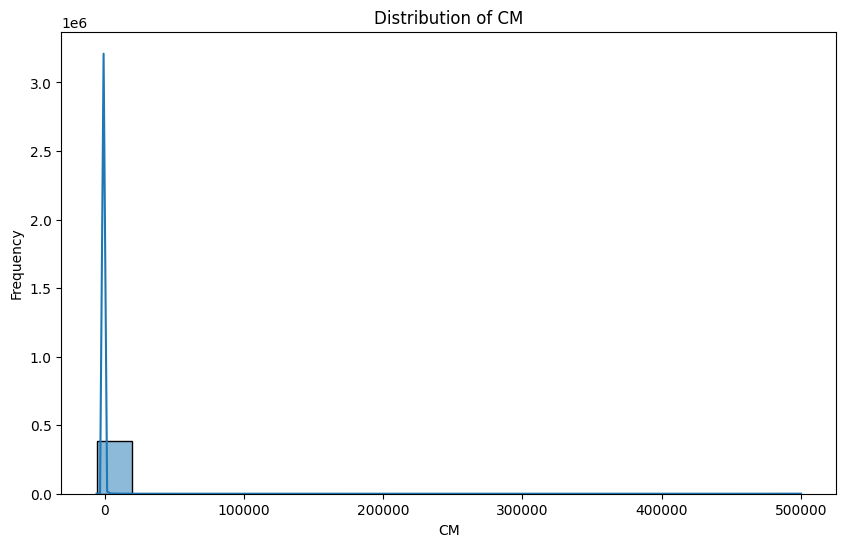

In [32]:
# Graphe de distribution de y_train['CM']

plt.figure(figsize=(10, 6))
sns.histplot(y_train['CM'], kde=True)
plt.title('Distribution of CM')
plt.xlabel('CM')
plt.ylabel('Frequency')
plt.show()

La distribution du coût moyen (CM) présente les caractéristiques suivantes :

- Distribution extrêmement asymétrique à droite :
  - Une immense majorité des valeurs de CM sont proches de zéro ;
  - Quelques valeurs atteignent des niveaux très élevés (jusqu'à près de 500000), mais elles sont très rares.

- Concentration des observations :
  - Plus de 3 millions d'observations se situent dans l'intervalle 0 à quelques milliers d'euros, ce qui indique une forte concentration autour de petites valeurs ;
  - Cela suggère que la majorité des sinistres ont un coût moyen faible.

- Présence de valeurs extrêmes (outliers) :
  - Quelques sinistres présentent un coût exceptionnellement élevé.
  - Ces valeurs ont un poids potentiel important dans le calcul des métriques(RMSE, MAE…) et peuvent biaisser l'entraînement si non traitées.

L'examen de la distribution brute de `CM` révèle une **forte asymétrie à droite** : la majorité des valeurs sont très faibles (proches de zéro), tandis qu'une minorité présente des montants exceptionnellement élevés.

Ce comportement est typique des variables de type **coût de sinistres** ou **montants financiers**, souvent modélisées avec des **lois de Pareto**, **log-normales** ou **gamma**.

Une transformation logarithmique `log(CM + 1)` permettrait de :
  - Réduire l'effet des *outliers* ;
  - Rapprocher la distribution d'une loi normale, facilitant la modélisation ;
  - Améliorer la performance des modèles sensibles à la distribution.

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


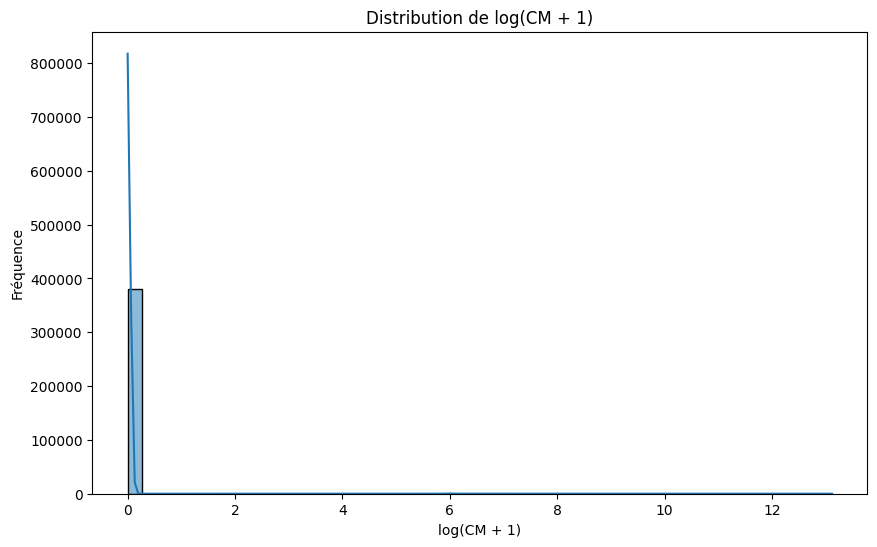

In [33]:
# Transformation log(CM + 1) pour réduire la variance et la dissymétrie
y_train['CM_log'] = np.log1p(y_train['CM'])  # log1p(x) = log(x + 1)

plt.figure(figsize=(10, 6))
sns.histplot(y_train['CM_log'], kde=True, bins=50)
plt.title('Distribution de log(CM + 1)')
plt.xlabel('log(CM + 1)')
plt.ylabel('Fréquence')
plt.show()


Même après transformation `log(CM + 1)`, la distribution reste ultra-concentrée autour de zéro, ce qui n'est pas l'effet attendu d'un `log-transform`. Cela suggère fortement que **la majorité des valeurs de CM sont nulles ou quasi-nulles**.
Vérifions cette hypothèse en deux temps :
1. Vérifier la proportion de zéros

In [34]:
zero_ratio = (y_train['CM'] == 0).mean()
print(f"Proportion de zéros dans CM : {zero_ratio:.2%}")

Proportion de zéros dans CM : 99.39%


2. Affiche la distribution sans les zéros

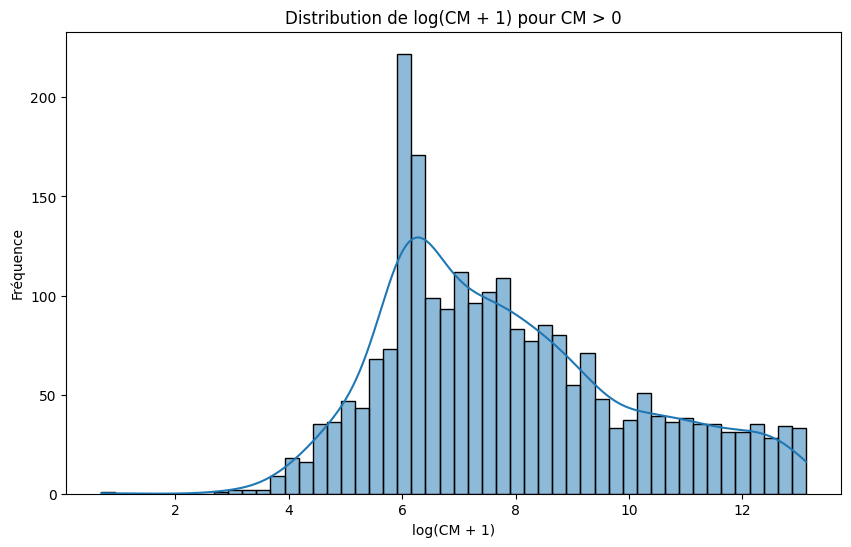

In [35]:
non_zero_cm = y_train[y_train['CM'] > 0]['CM']
log_non_zero_cm = np.log1p(non_zero_cm)

plt.figure(figsize=(10, 6))
sns.histplot(log_non_zero_cm, kde=True, bins=50)
plt.title("Distribution de log(CM + 1) pour CM > 0")
plt.xlabel("log(CM + 1)")
plt.ylabel("Fréquence")
plt.show()

Plusieur éléments se dégagent de la transformation logarithmique sur les observations strictement positives (`CM > 0`) :

1. **Réduction de l'asymétrie**  
   La transformation logarithmique a permis de corriger l'asymétrie extrême initialement observée dans la distribution brute de `CM`. Elle :
   - compresse l'effet des très grandes valeurs (*outliers*),
   - met mieux en évidence la structure sous-jacente des montants courants.

2. **Distribution toujours asymétrique à droite**  
   Malgré la transformation, la distribution reste légèrement étalée vers la droite, ce qui reflète la nature typiquement déséquilibrée des montants de sinistres (une majorité de petits montants, quelques très gros).

3. Le mode, qui constitue la valeur la plus fréquente dans une série de données, se situe autour de `log(CM + 1) ≈ 6`: Cela correspond à un coût de sinistre typique de `exp(6) - 1 ≈ 400 €`, valeur qui semble représenter un sinistre "standard" dans le jeu de données.

Nous pouvons en déduire que cette transformation rend la variable cible plus adaptée à une régression, notamment linéaire, en :
  - réduisant la variance,
  - limitant le poids des valeurs extrêmes,
  - facilitant la convergence des modèles.

- Elle améliore également la **robustesse** des algorithmes face aux déséquilibres structurels inhérents aux données assurantielles.

> Cette transformation est particulièrement utile dans une stratégie en deux étapes :  
> 1. modèle binaire de prédiction de la survenue d'un sinistre (`CM > 0`),  
> 2. régression sur `log(CM + 1)` conditionnée à `CM > 0`.

In [ ]:
# 1. Création de la cible binaire (sinistre ou non)
y_train_bin = (y_train['CM'] > 0).astype(int)

# Séparation des données pour la phase de test
X_tr, X_val, y_bin_tr, y_bin_val = train_test_split(X_train_enc, y_train_bin, test_size=0.2, random_state=42)

# 2. Étape 1 - Modèle de classification binaire : prédire si CM > 0
clf = LogisticRegression(max_iter=1000)
clf.fit(X_tr, y_bin_tr)

# Prédictions de probabilité d’avoir un sinistre
proba_sinistre = clf.predict_proba(X_val)[:, 1]

# Évaluation du modèle binaire
auc = roc_auc_score(y_bin_val, proba_sinistre)
print(f"AUC (CM > 0): {auc:.4f}")

# 3. Étape 2 - Modèle de régression conditionnelle sur CM > 0
# Filtrage sur les cas avec sinistre
X_train_pos = X_train_enc[y_train['CM'] > 0]
y_train_logcm = np.log1p(y_train['CM'][y_train['CM'] > 0])

# Séparation pour validation
X_tr2, X_val2, y_tr2, y_val2 = train_test_split(X_train_pos, y_train_logcm, test_size=0.2, random_state=42)

# Régression sur log(CM + 1)
reg = Ridge(alpha=1.0)
reg.fit(X_tr2, y_tr2)

# Prédictions
y_pred_log = reg.predict(X_val2)
rmse = mean_squared_error(y_val2, y_pred_log)
print(f"RMSE sur log(CM + 1): {rmse:.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC (CM > 0): 0.7371
RMSE sur log(CM + 1): 5.5240


#### Analyse des performances du modèle

#### 1. AUC (CM > 0) = **0.7371**

L'AUC (*Area Under the Curve*) évalue la capacité du modèle à distinguer les observations où `CM > 0` (existence d'un sinistre) de celles où `CM = 0` (absence de sinistre).  
Une AUC de **0.7371** indique une **bonne performance de discrimination** :  
- Le modèle parvient à capter un signal pertinent.
- Il est significativement meilleur que le hasard (AUC = 0.5).
- Cela ouvre la voie à des **applications utiles pour le scoring ou la priorisation du risque**.

#### 2. RMSE sur `log(CM + 1)` = **5.5240**

Le RMSE est calculé ici sur la transformation logarithmique `log(CM + 1)`, souvent utilisée pour réduire l'impact des outliers dans une distribution très asymétrique.  
Une erreur de 5.5240 en log se traduit par une erreur moyenne d’environ :

$$
e^{5.5240} - 1 \approx 250 \text{ €}
$$

Cela signifie qu'en moyenne, le modèle se trompe d'environ 250 € sur la prédiction du coût sinistre.  
C'est une erreur significative si la plupart des sinistres sont faibles, mais raisonnable si la distribution comporte de nombreux sinistres très élevés.

Ainsi :

- Le modèle **discrimine correctement** la survenue d'un sinistre (AUC satisfaisante).
- L'estimation du coût (RMSE) est perfectible, probablement à cause de la **présence d’outliers** importants.
- Des améliorations possibles :
  - Approche **en deux étapes** : classification (CM > 0) + régression sur les cas sinistrés.
  - Utilisation de modèles **robustes aux valeurs extrêmes**.
  - Test de **transformations alternatives** ou pondérations adaptées au domaine assurantiel.
